In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

plt.rcParams.update({'font.size': 12})

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set directory to location of OULAD dataset in google drive

In [3]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [4]:
ls

all_f1.pdf            learning_behaviour_f1.pdf
all_npv.pdf           learning_behaviour_npv.pdf
anonymisedOUDataSet/  pass_fail_rate_modules.pdf
Deadline/             performance_f1.pdf
demographic_f1.pdf    performance_npv.pdf
demographic_npv.pdf   StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [5]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# All Modules

## Setup

### Load dataset and remove column features that are not used in module

In [6]:
deadline_list = [0, 50, 100, 150, 200, 250]
module_titles = ["Module FFF", "Module EEE", "Module BBB"]
classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

df_FFF = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_FFF_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # pass course = 0 | fail course = 1
  temp['final_result'] = temp['final_result'].replace({1:1, 2:0, 3:0})
  df_FFF[i] = temp


df_EEE = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_EEE_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # pass course = 0 | fail course = 1
  temp['final_result'] = temp['final_result'].replace({1:1, 2:0, 3:0})
  df_EEE[i] = temp

df_BBB = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_BBB_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # pass course = 0 | fail course = 1
  temp['final_result'] = temp['final_result'].replace({1:1, 2:0, 3:0})
  df_BBB[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Helper functions

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [8]:
def plot_confusion_matrix(result):
  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):
      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [9]:
def plot_days_compare(deadline_list,result,labels,title,modules,pdf_filename):

  fig, axs = plt.subplots(1, 3,figsize=(15, 5))
  fig.suptitle(title, y=1.07)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.2)
  for index, ax_i in enumerate(axs):
    for i in range(len(result[index])):

      plt_days = sns.lineplot(x=deadline_list,y=np.array(result[index][i], dtype=object)[:,1],marker="o", label=labels[i], ax=ax_i, legend=False)


      plt_days.set_title(modules[index])
      plt_days.set_ylabel("F1 Score")
  fig.text(0.5,-0.04, 'Number of days through module', ha='center', fontsize=13)

  fig.legend(axs, labels = labels, bbox_to_anchor=(1.01,0.58), loc="center left")
  plt.savefig(pdf_filename, bbox_inches="tight")

In [10]:
def plot_days_compare_npv(deadline_list,result,labels,title,modules,pdf_filename):

  fig, axs = plt.subplots(1, 3,figsize=(15, 5))
  fig.suptitle(title, y=1.07)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.2)
  for index, ax_i in enumerate(axs):
    for i in range(len(result[index])):

      npv = []

      for j in np.array(result[index][i], dtype=object)[:,4]:
        tn, fp, fn, tp = j.ravel()

        # Prevent zero division error
        if fn == 0:
          npv.append(0)
        else:
          npv.append(tn/(tn+fn))

      plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i], ax=ax_i, legend=False)


      plt_days.set_title(modules[index])
      plt_days.set_ylabel("Negative Predictive Value")
  fig.text(0.5,-0.04, 'Number of days through module', ha='center', fontsize=13)

  fig.legend(axs, labels = labels, bbox_to_anchor=(1.01,0.58), loc="center left")
  plt.savefig(pdf_filename, bbox_inches="tight")

In [11]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [12]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [13]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [14]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [15]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [16]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [17]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [19]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Make predictions

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [21]:
demographic_df_FFF = {}
for i in df_FFF.keys():
  demographic_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['demographic'], include_final_result=True)

demographic_df_EEE = {}
for i in df_EEE.keys():
  demographic_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['demographic'], include_final_result=True)

demographic_df_BBB = {}
for i in df_BBB.keys():
  demographic_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['demographic'], include_final_result=True)

###### Encode data

In [22]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(demographic_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(demographic_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(demographic_df_BBB, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(

###### Feature selection

In [23]:
for i in df_FFF.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train_FFF[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_FFF[i], Y_train_FFF[i]))
  
  X_test_FFF[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_FFF[i]))


for i in df_EEE.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train_EEE[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_EEE[i], Y_train_EEE[i]))
  
  X_test_EEE[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_EEE[i]))


for i in df_BBB.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train_BBB[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_BBB[i], Y_train_BBB[i]))
  
  X_test_BBB[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_BBB[i]))

##### DummyClassifier

In [24]:
from sklearn.dummy import DummyClassifier

def demographic_du(df,X_train,Y_train,X_test,Y_test):
  demographic_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return demographic_results_du

In [25]:
demographic_results_du_FFF = demographic_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_du_EEE = demographic_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_du_BBB = demographic_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.470
Best parameters set:
Accuracy: 0.4939301972685888, F1 Score: 0.3214649033570702, Precision: 0.2404870624048706, Recall: 0.48466257668711654


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best param

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [26]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

def demographic_nb(df,X_train,Y_train,X_test,Y_test):
  demographic_results_nb = []

  pipeline = Pipeline([
      ('clf', BernoulliNB(binarize=None)),
  ])

  params = {
    #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_nb

In [27]:
demographic_results_nb_FFF = demographic_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_nb_EEE = demographic_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_nb_BBB = demographic_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.562
Best parameters set:
Accuracy: 0.7071320182094082, F1 Score: 0.339041095890411, Precision: 0.38372093023255816, Recall: 0.30368098159509205


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.7150108774474256, F1 Score: 0.31173380035026266, Precision: 0.3771186440677966, Recall: 0.2656716417910448


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.713150289017341, F1 Score: 0.3095652173913044, Precision: 0.3771186440677966, Recall: 0.26253687315634217


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.558
Be

##### LogisticRegression

ovr is used for binary problems

In [28]:
from sklearn.linear_model import LogisticRegression

def demographic_lr(df,X_train,Y_train,X_test,Y_test):
  demographic_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(multi_class='ovr')),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_lr

In [29]:
demographic_results_lr_FFF = demographic_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_lr_EEE = demographic_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_lr_BBB = demographic_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.516
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7503793626707133, F1 Score: 0.19164619164619162, Precision: 0.48148148148148145, Recall: 0.1196319018404908


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7469180565627266, F1 Score: 0.1749408983451537, Precision: 0.42045454545454547, Recall: 0.11044776119402985


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.744942196531792, F1 Score: 0.17330210772833723, Precision: 0.42045454545454547, Recall: 0.109144

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.459
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.824203821656051, F1 Score: 0.014285714285714287, Precision: 0.25, Recall: 0.007352941176470588


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.458
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8250950570342205, F1 Score: 0.014285714285714285, Precision: 0.3333333333333333, Recall: 0.0072992700729927005


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.458
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8253164556962025, F1 Score: 0.014285714285714285, Precision: 0.3333333333333333, Recall: 0.0072992700729927005


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalli

##### WeightedLogisticRegression

In [30]:
def demographic_lrw(df,X_train,Y_train,X_test,Y_test):
  demographic_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_lrw

In [31]:
demographic_results_lrw_FFF = demographic_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_lrw_EEE = demographic_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_lrw_BBB = demographic_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.569
Best parameters set:
Accuracy: 0.5842185128983308, F1 Score: 0.38565022421524664, Precision: 0.303886925795053, Recall: 0.5276073619631901


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5808556925308195, F1 Score: 0.39791666666666664, Precision: 0.3056, Recall: 0.5701492537313433


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5802023121387283, F1 Score: 0.39792746113989635, Precision: 0.30670926517571884, Recall: 0.5663716814159292


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.566
Best paramete

##### RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier

def demographic_rf(df,X_train,Y_train,X_test,Y_test):

  demographic_results_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_rf.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_rf

In [33]:
demographic_results_rf_FFF = demographic_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_rf_EEE = demographic_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_rf_BBB = demographic_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.557
Best parameters set:
	clf__n_estimators: 110
Accuracy: 0.6092564491654021, F1 Score: 0.3302990897269181, Precision: 0.2866817155756208, Recall: 0.3895705521472393


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.549
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.5902828136330674, F1 Score: 0.31013431013431014, Precision: 0.26239669421487605, Recall: 0.37910447761194027


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.549
Best parameters set:
	clf__n_estim

##### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

def demographic_ab(df,X_train,Y_train,X_test,Y_test):
  demographic_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return demographic_results_ab

In [35]:
demographic_results_ab_FFF = demographic_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_ab_EEE = demographic_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_ab_BBB = demographic_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.526
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7382397572078907, F1 Score: 0.23841059602649, Precision: 0.4251968503937008, Recall: 0.1656441717791411


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7469180565627266, F1 Score: 0.1749408983451537, Precision: 0.42045454545454547, Recall: 0.11044776119402985


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.744942196531792, F1 Sc

##### Plot results overview

In [36]:
demographic_classifier_results_FFF = [demographic_results_du_FFF, demographic_results_nb_FFF, demographic_results_lr_FFF, demographic_results_lrw_FFF, demographic_results_rf_FFF, demographic_results_ab_FFF]
demographic_classifier_results_EEE = [demographic_results_du_EEE, demographic_results_nb_EEE, demographic_results_lr_EEE, demographic_results_lrw_EEE, demographic_results_rf_EEE, demographic_results_ab_EEE]
demographic_classifier_results_BBB = [demographic_results_du_BBB, demographic_results_nb_BBB, demographic_results_lr_BBB, demographic_results_lrw_BBB, demographic_results_rf_BBB, demographic_results_ab_BBB]

demographic_classifier_results = [demographic_classifier_results_FFF,demographic_classifier_results_EEE,demographic_classifier_results_BBB]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


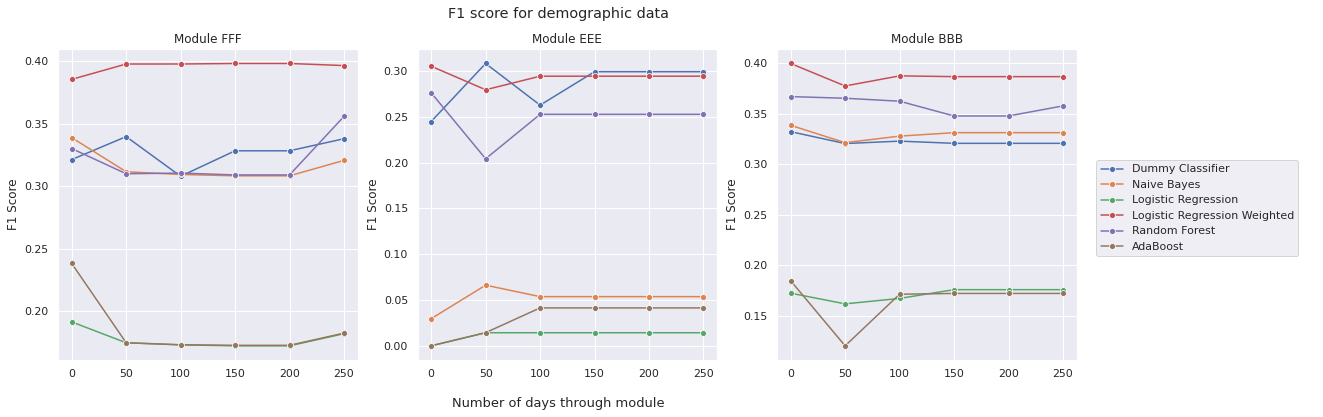

In [37]:
plot_days_compare(deadline_list,demographic_classifier_results,classifier_labels, "F1 score for demographic data", module_titles, "demographic_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


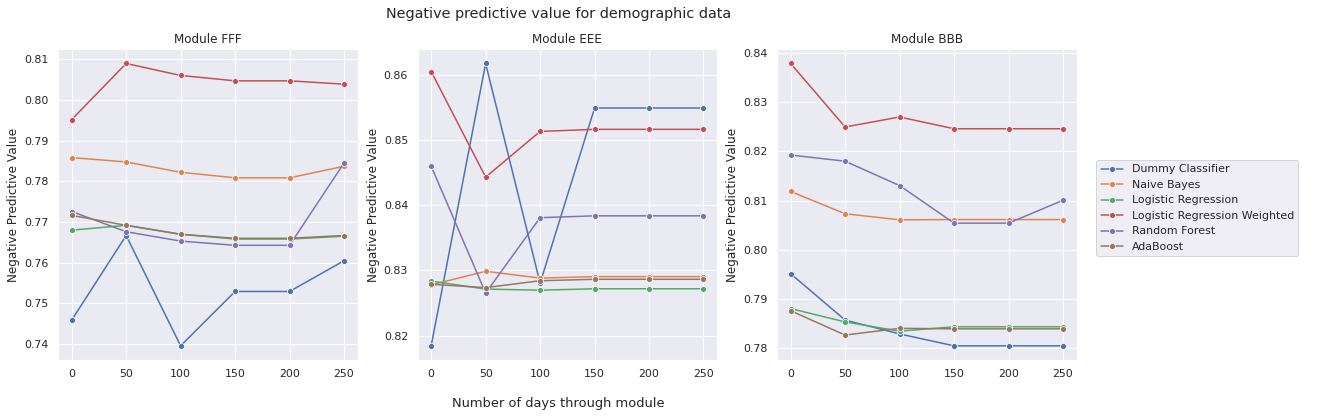

In [38]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,classifier_labels, "Negative predictive value for demographic data", module_titles, "demographic_npv.pdf")

#### Learning behaviour data

##### Prepare data for prediction

In [39]:
learning_behaviour_df_FFF = {}
for i in df_FFF.keys():
  learning_behaviour_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['learning_behaviour'], include_final_result=True)

learning_behaviour_df_EEE = {}
for i in df_EEE.keys():
  learning_behaviour_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['learning_behaviour'], include_final_result=True)

learning_behaviour_df_BBB = {}
for i in df_BBB.keys():
  learning_behaviour_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['learning_behaviour'], include_final_result=True)

###### Encode data

In [40]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(learning_behaviour_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(learning_behaviour_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(learning_behaviour_df_BBB, ["2013J"], "2014J")

Index([], dtype='object') Index(['quiz', 'dualpane', 'subpage', 'url', 'glossary', 'mean_click',
       'ouwiki', 'forumng', 'homepage', 'questionnaire', 'page', 'oucontent',
       'resource', 'oucollaborate'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'dualpane', 'subpage', 'url', 'glossary', 'mean_click',
       'ouwiki', 'forumng', 'homepage', 'questionnaire', 'page', 'oucontent',
       'resource', 'oucollaborate'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'dualpane', 'subpage', 'url', 'glossary', 'mean_click',
       'ouwiki', 'repeatactivity', 'forumng', 'homepage', 'questionnaire',
       'page', 'oucontent', 'resource', 'oucollaborate'],
      dtype='object')
Index([], dtype='object') Index(['dualpane', 'ouwiki', 'homepage', 'dataplus', 'subpage',
       'repeatactivity', 'oucontent', 'quiz', 'url', 'glossary', 'forumng',
       'page', 'resource', 'folder', 'oucollaborate', 'mean_click',
       'questionnaire'],
      dtype='object')

###### Feature selection

In [41]:
for i in df_FFF.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train_FFF[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_FFF[i], Y_train_FFF[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train_FFF[i].index)
  
  X_test_FFF[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_FFF[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test_FFF[i].index)

for i in df_EEE.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train_EEE[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_EEE[i], Y_train_EEE[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train_EEE[i].index)
  
  X_test_EEE[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_EEE[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test_EEE[i].index)


for i in df_BBB.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train_BBB[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_BBB[i], Y_train_BBB[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train_BBB[i].index)
  
  X_test_BBB[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_BBB[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test_BBB[i].index)

##### DummyClassifier

In [42]:
def learning_behaviour_du(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return learning_behaviour_results_du

In [43]:
learning_behaviour_results_du_FFF = learning_behaviour_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_du_EEE = learning_behaviour_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_du_BBB = learning_behaviour_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.470
Best parameters set:
Accuracy: 0.4939301972685888, F1 Score: 0.3214649033570702, Precision: 0.2404870624048706, Recall: 0.48466257668711654


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best param

##### NaiveBayes

In [44]:
def learning_behaviour_nb(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_nb = []

  pipeline = Pipeline([
      ('clf', ComplementNB()),
  ])

  params = {
    #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return learning_behaviour_results_nb

In [45]:
learning_behaviour_results_nb_FFF = learning_behaviour_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_nb_EEE = learning_behaviour_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_nb_BBB = learning_behaviour_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.495
Best parameters set:
Accuracy: 0.4317147192716237, F1 Score: 0.39056143205858423, Precision: 0.26578073089701, Recall: 0.7361963190184049


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.635
Best parameters set:
Accuracy: 0.5373459028281363, F1 Score: 0.4480968858131488, Precision: 0.315468940316687, Recall: 0.7731343283582089


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.657
Best parameters set:
Accuracy: 0.5252890173410405, F1 Score: 0.4446322907861369, Precision: 0.31161137440758296, Recall: 0.775811209439528


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.663
Best p

##### LogisticRegression

In [46]:
def learning_behaviour_lr(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression()),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return learning_behaviour_results_lr

In [47]:
learning_behaviour_results_lr_FFF = learning_behaviour_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_lr_EEE = learning_behaviour_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_lr_BBB = learning_behaviour_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.414
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7526555386949925, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.634
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7737490935460478, F1 Score: 0.4507042253521127, Precision: 0.5493562231759657, Recall: 0.382089552238806


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.655
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7644508670520231, F1 Score: 0.4436860068259386, Precision: 0.5263157894736842, Recall: 0.3834808259587021


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.669
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7792207792207793, F1 Score: 0.4631578947368421, Precision: 0.5764192139737991, Recall: 0.3870967741935484


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalli

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.494
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8267515923566879, F1 Score: 0.04225352112676056, Precision: 0.5, Recall: 0.022058823529411766


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.491
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.826362484157161, F1 Score: 0.08053691275167786, Precision: 0.5, Recall: 0.043795620437956206


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.720
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8227848101265823, F1 Score: 0.3577981651376147, Precision: 0.48148148148148145, Recall: 0.2846715328467153


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.539
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7318244170096022, F1 Score: 0.3079646017699115, Precision: 0.3625, Recall: 0.2676923076923077


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.600
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7113821138211383, F1 Score: 0.4, Precision: 0.376657824933687, Recall: 0.4264264264264264


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.615
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7373053486797563, F1 Score: 0.4226190476190476, Precision: 0.42011834319526625, Recall: 0.4251497005988024


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.73

##### WeightedLogisticRegression

In [48]:
def learning_behaviour_lrw(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(class_weight = 'balanced')),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return learning_behaviour_results_lrw

In [49]:
learning_behaviour_results_lrw_FFF = learning_behaviour_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_lrw_EEE = learning_behaviour_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_lrw_BBB = learning_behaviour_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.589
Best parameters set:
Accuracy: 0.5887708649468892, F1 Score: 0.45799999999999996, Precision: 0.3397626112759644, Recall: 0.7024539877300614


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.667
Best parameters set:
Accuracy: 0.6446700507614214, F1 Score: 0.48202959830866815, Precision: 0.37315875613747956, Recall: 0.6805970149253732


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.677
Best parameters set:
Accuracy: 0.6459537572254336, F1 Score: 0.4969199178644764, Precision: 0.38110236220472443, Recall: 0.7138643067846607


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.693


##### RandomForest

In [50]:
def learning_behaviour_rf(df,X_train,Y_train,X_test,Y_test):

  learning_behaviour_results_rf = []
  learning_behaviour_features_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
    learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])

    print("\n")

  return learning_behaviour_results_rf, learning_behaviour_features_rf

In [51]:
learning_behaviour_results_rf_FFF,learning_behaviour_features_rf_FFF = learning_behaviour_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_rf_EEE,learning_behaviour_features_rf_EEE = learning_behaviour_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_rf_BBB,learning_behaviour_features_rf_BBB = learning_behaviour_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.568
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.6828528072837633, F1 Score: 0.30794701986754963, Precision: 0.3345323741007194, Recall: 0.2852760736196319


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.602
Best parameters set:
	clf__n_estimators: 80
Accuracy: 0.7331399564902102, F1 Score: 0.39672131147540984, Precision: 0.44, Recall: 0.3611940298507463


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.619
Best parameters set:
	clf__n_estimators: 70
Accura

##### AdaBoost

In [52]:
def learning_behaviour_ab(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return learning_behaviour_results_ab

In [53]:
learning_behaviour_results_ab_FFF = learning_behaviour_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_ab_EEE = learning_behaviour_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_ab_BBB = learning_behaviour_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.520
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.7207890743550834, F1 Score: 0.34050179211469533, Precision: 0.40948275862068967, Recall: 0.29141104294478526


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.655
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.7541696881798404, F1 Score: 0.45410628019323673, Precision: 0.493006993006993, Recall: 0.4208955223880597


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.665
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.73843930635838

##### Plot results overview

In [54]:
learning_behaviour_classifier_results_FFF = [learning_behaviour_results_du_FFF, learning_behaviour_results_nb_FFF, learning_behaviour_results_lr_FFF, learning_behaviour_results_lrw_FFF, learning_behaviour_results_rf_FFF, learning_behaviour_results_ab_FFF]
learning_behaviour_classifier_results_EEE = [learning_behaviour_results_du_EEE, learning_behaviour_results_nb_EEE, learning_behaviour_results_lr_EEE, learning_behaviour_results_lrw_EEE, learning_behaviour_results_rf_EEE, learning_behaviour_results_ab_EEE]
learning_behaviour_classifier_results_BBB = [learning_behaviour_results_du_BBB, learning_behaviour_results_nb_BBB, learning_behaviour_results_lr_BBB, learning_behaviour_results_lrw_BBB, learning_behaviour_results_rf_BBB, learning_behaviour_results_ab_BBB]

learning_behaviour_classifier_results = [learning_behaviour_classifier_results_FFF,learning_behaviour_classifier_results_EEE,learning_behaviour_classifier_results_BBB]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


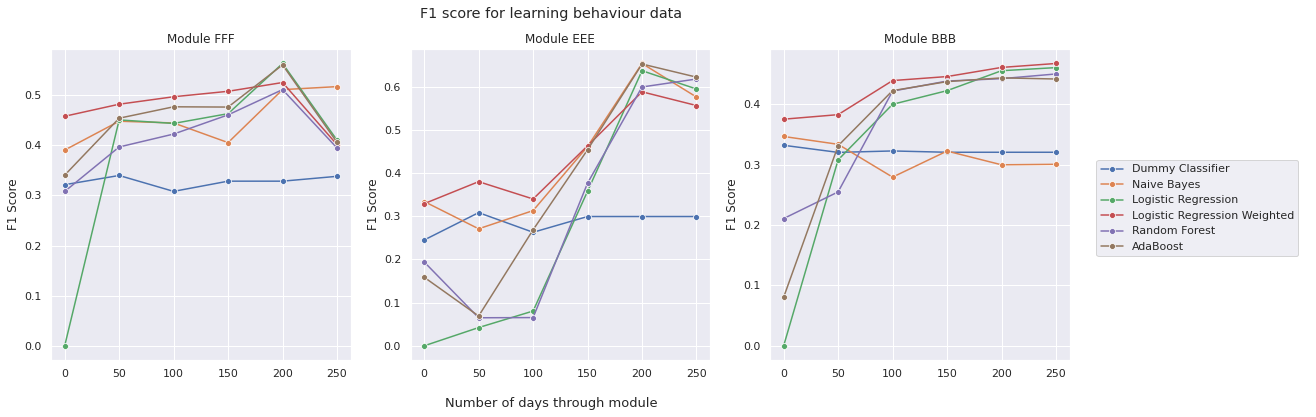

In [55]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,classifier_labels, "F1 score for learning behaviour data", module_titles, "learning_behaviour_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


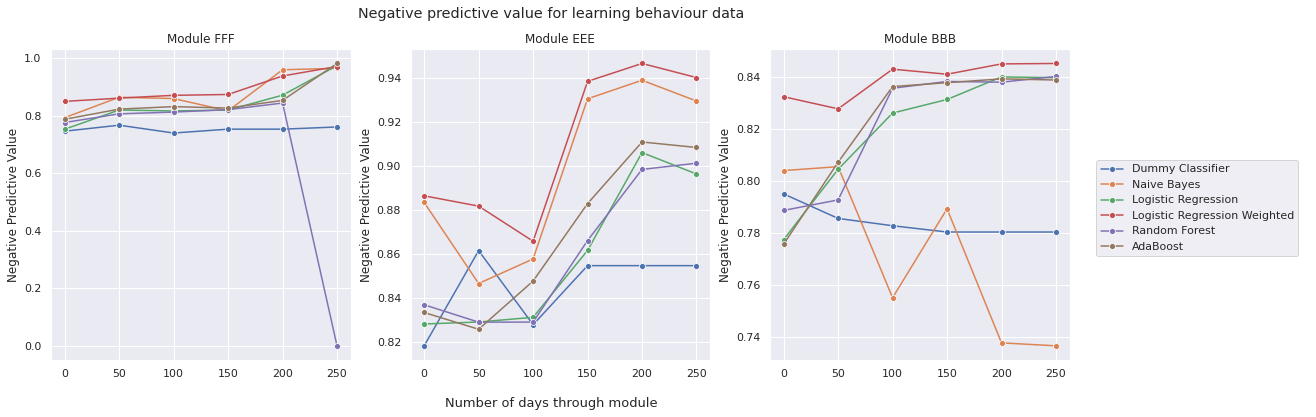

In [56]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,classifier_labels, "Negative predictive value for learning behaviour data", module_titles, "learning_behaviour_npv.pdf")

#### Performance data

##### Prepare data for prediction

In [57]:
performance_df_FFF = {}
for i in df_FFF.keys():
  performance_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['performance'], include_final_result=True)

performance_df_EEE = {}
for i in df_EEE.keys():
  performance_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['performance'], include_final_result=True)

performance_df_BBB = {}
for i in df_BBB.keys():
  performance_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['performance'], include_final_result=True)

In [58]:
performance_df_FFF[50]

,code_presentation,id_student,weighted_score,score,final_result
0,2013B,33915,22.680,90.0,0
1,2013B,35544,21.672,86.0,0
2,2013B,35860,21.168,84.0,0
3,2013B,42668,18.648,74.0,0
4,2013B,43273,20.412,81.0,0
...,...,...,...,...,...
4797,2014J,2681198,8.316,66.0,0
4798,2014J,2682682,12.096,96.0,0
4799,2014J,2683857,9.072,72.0,0
4800,2014J,2693932,11.340,90.0,0


###### Encode data

In [59]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(performance_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(performance_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(performance_df_BBB, ["2013J"], "2014J")

Index([], dtype='object') Index([], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index([], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index([], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object

##### DummyClassifier

In [60]:
def performance_du(df,X_train,Y_train,X_test,Y_test):
  performance_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return performance_results_du

In [61]:
performance_results_du_FFF = performance_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_du_EEE = performance_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_du_BBB = performance_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.49855699855699853, F1 Score: 0.3285024154589372, Precision: 0.24495677233429394, Recall: 0.49853372434017595


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best p

##### NaiveBayes

In [62]:
def performance_nb(df,X_train,Y_train,X_test,Y_test):
  performance_results_nb = []

  pipeline = Pipeline([
      ('clf', ComplementNB()),
  ])

  params = {
    #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return performance_results_nb

In [63]:
performance_results_nb_FFF = performance_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_nb_EEE = performance_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_nb_BBB = performance_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.628
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.804
Best parameters set:
Accuracy: 0.8569364161849711, F1 Score: 0.5991902834008097, Precision: 0.9548387096774194, Recall: 0.4365781710914454


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.842
Best parameters set:
Accuracy: 0.886002886002886, F1 Score: 0.7168458781362008, Precision: 0.9216589861751152, Recall: 0.5865102639296188


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.851
Best parameters set

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best parameters set:
Accuracy: 0.9088607594936708, F1 Score: 0.7049180327868853, Precision: 0.8037383177570093, Recall: 0.6277372262773723


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.832
Best parameters set:
Accuracy: 0.9088607594936708, F1 Score: 0.7049180327868853, Precision: 0.8037383177570093, Recall: 0.6277372262773723


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.634
Best parameters set:
Accuracy: 0.22633744855967078, F1 Score: 0.3627118644067796, Precision: 0.22214532871972317, Recall: 0.9876923076923076


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.754
Best parameters set:
Accuracy: 0.22560975609756098, F1 Score: 0.3681592039800995, Precision: 0.22560975609756098, Recall: 1.0


Day 150
Perform

##### LogisticRegression

In [64]:
def performance_lr(df,X_train,Y_train,X_test,Y_test):
  performance_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression()),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return performance_results_lr

In [65]:
performance_results_lr_FFF = performance_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_lr_EEE = performance_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_lr_BBB = performance_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.709
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.853
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8663294797687862, F1 Score: 0.669051878354204, Precision: 0.85, Recall: 0.551622418879056


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.878
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.8845598845598845, F1 Score: 0.7250859106529209, Precision: 0.8755186721991701, Recall: 0.6187683284457478


Day 200
Performing grid se

##### WeightedLogisticRegression

In [66]:
def performance_lrw(df,X_train,Y_train,X_test,Y_test):
  performance_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(class_weight = 'balanced')),
  ])

  params = {
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return performance_results_lrw

In [67]:
performance_results_lrw_FFF = performance_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_lrw_EEE = performance_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_lrw_BBB = performance_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.732
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.835
Best parameters set:
Accuracy: 0.8677745664739884, F1 Score: 0.7109004739336493, Precision: 0.7653061224489796, Recall: 0.6637168141592921


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.870
Best parameters set:
Accuracy: 0.8852813852813853, F1 Score: 0.7609022556390977, Precision: 0.7808641975308642, Recall: 0.7419354838709677


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.868
Best parameters se

##### RandomForest

In [68]:
def performance_rf(df,X_train,Y_train,X_test,Y_test):

  performance_results_rf = []
  performance_features_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_rf.append([acc, f1, prec, recall, conf])
    performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])

    print("\n")

  return performance_results_rf, performance_features_rf

In [69]:
performance_results_rf_FFF,performance_features_rf_FFF = performance_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_rf_EEE,performance_features_rf_EEE = performance_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_rf_BBB,performance_features_rf_BBB = performance_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.729
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.807
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.8280346820809249, F1 Score: 0.628125, Precision: 0.6677740863787376, Recall: 0.5929203539823009


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.856
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.876623

##### AdaBoost

In [70]:
def performance_ab(df,X_train,Y_train,X_test,Y_test):
  performance_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return performance_results_ab

In [71]:
performance_results_ab_FFF = performance_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_ab_EEE = performance_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_ab_BBB = performance_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.704
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.30021754894851344, F1 Score: 0.40173589584624925, Precision: 0.2535211267605634, Recall: 0.9671641791044776


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.845
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.865606936416185, F1 Score: 0.6381322957198444, Precision: 0.9371428571428572, Recall: 0.4837758112094395


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.870
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.87734487734487

##### Plot results overview

In [72]:
performance_classifier_results_FFF = [performance_results_du_FFF, performance_results_nb_FFF, performance_results_lr_FFF, performance_results_lrw_FFF, performance_results_rf_FFF, performance_results_ab_FFF]
performance_classifier_results_EEE = [performance_results_du_EEE, performance_results_nb_EEE, performance_results_lr_EEE, performance_results_lrw_EEE, performance_results_rf_EEE, performance_results_ab_EEE]
performance_classifier_results_BBB = [performance_results_du_BBB, performance_results_nb_BBB, performance_results_lr_BBB, performance_results_lrw_BBB, performance_results_rf_BBB, performance_results_ab_BBB]

performance_classifier_results = [performance_classifier_results_FFF,performance_classifier_results_EEE,performance_classifier_results_BBB]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


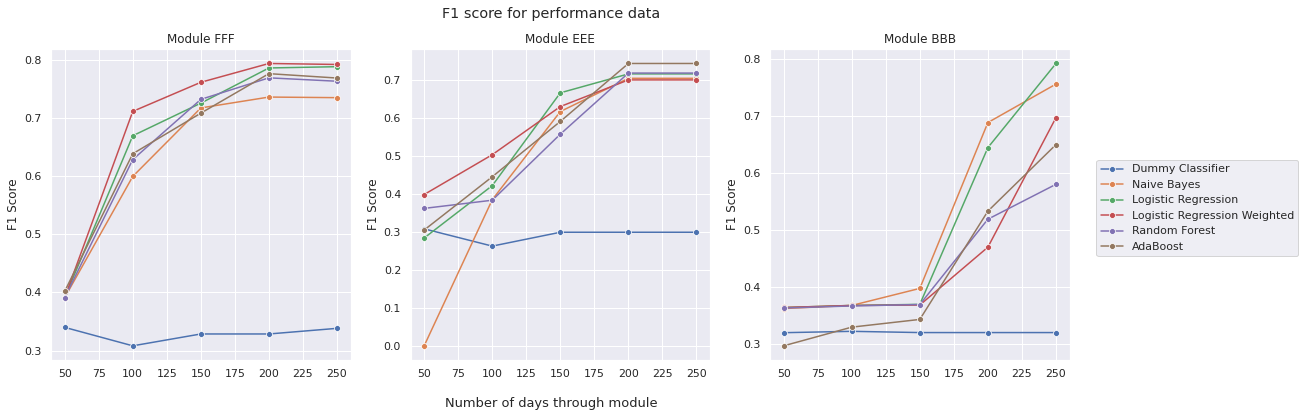

In [73]:
plot_days_compare(deadline_list[1:],performance_classifier_results,classifier_labels, "F1 score for performance data", module_titles, "performance_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


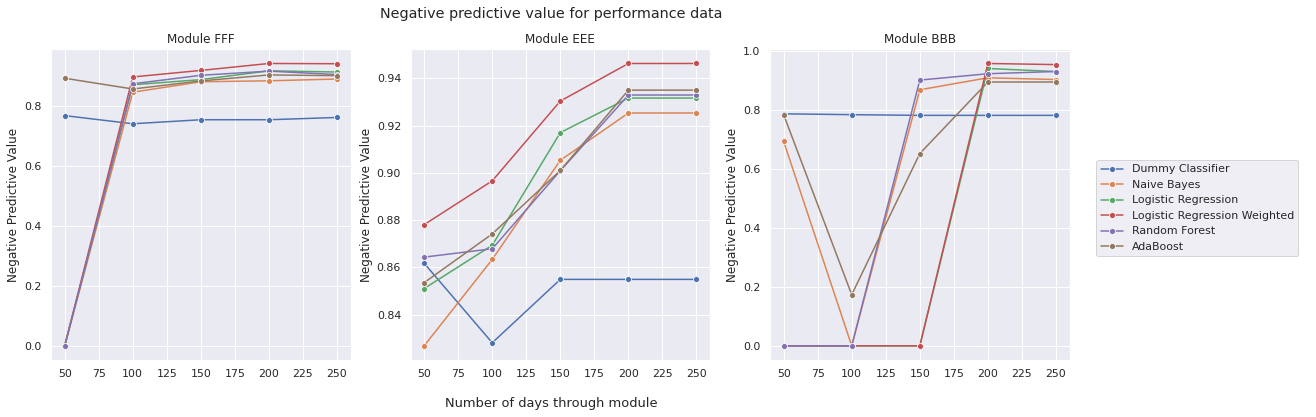

In [74]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,classifier_labels, "Negative predictive value for performance data", module_titles, "performance_npv.pdf")

#### All data (Demographic, Learning Behaviour, Performance)

##### Prepare data for prediction

In [75]:
all_df_FFF = {}
for i in df_FFF.keys():
  all_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

all_df_EEE = {}
for i in df_EEE.keys():
  all_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

all_df_BBB = {}
for i in df_BBB.keys():
  all_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [76]:
for i in list(df_FFF)[1:2]:
  all_df_FFF[i] = all_df_FFF[i].drop(columns=["score","weighted_score"])

for i in list(df_FFF)[2:]:
  all_df_FFF[i] = all_df_FFF[i].drop(columns=["score"])


for i in list(df_EEE)[1:1]:
  all_df_EEE[i] = all_df_EEE[i].drop(columns=["score","weighted_score"])

for i in list(df_EEE)[1:]:
  all_df_EEE[i] = all_df_EEE[i].drop(columns=["score"])


for i in list(df_BBB)[1:-2]:
  all_df_BBB[i] = all_df_BBB[i].drop(columns=["score","weighted_score"])

for i in list(df_BBB)[-2:]:
  all_df_BBB[i] = all_df_BBB[i].drop(columns=["score"])

###### Encode data

In [77]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(all_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(all_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(all_df_BBB, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['quiz', 'dualpane', 'subpage', 'url', 'glossary', 'mean_click',
       'ouwiki', 'forumng', 'homepage', 'questionnaire', 'page', 'oucontent',
       'resource', 'oucollaborate'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['quiz', 'dualpane', 'subpage', 'url', 'glossary', 'mean_click',
       'ouwiki', 'forumng', 'homepage', 'questionnaire', 'page', 'oucontent',
       'resource', 'oucollaborate'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['quiz', 'dualpane', 'subpage', 'url', 'glossary', 'mean_click',
       'ouwiki', 'repeatactivity', 'forumng', 'homepage', 'questionnaire',
       'page', 'oucontent', 'resource', 'oucollaborate', 'weighted_score'],
      dtype='o

###### Reduce dimensions

In [78]:
for i in df_FFF.keys():
  pca = PCA(n_components='mle')

  X_train_FFF[i] = pca.fit_transform(X_train_FFF[i], Y_train_FFF[i])                             
  
  X_test_FFF[i] = pca.transform(X_test_FFF[i])


for i in df_EEE.keys():
  pca = PCA(n_components='mle')

  X_train_EEE[i] = pca.fit_transform(X_train_EEE[i], Y_train_EEE[i])                             
  
  X_test_EEE[i] = pca.transform(X_test_EEE[i])


for i in df_BBB.keys():
  pca = PCA(n_components='mle')

  X_train_BBB[i] = pca.fit_transform(X_train_BBB[i], Y_train_BBB[i])                             
  
  X_test_BBB[i] = pca.transform(X_test_BBB[i])

###### Feature selection

In [79]:
for i in df_FFF.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train_FFF[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_FFF[i], Y_train_FFF[i]))

  X_test_FFF[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_FFF[i]))

for i in df_EEE.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train_EEE[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_EEE[i], Y_train_EEE[i]))

  X_test_EEE[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_EEE[i]))


for i in df_BBB.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train_BBB[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_BBB[i], Y_train_BBB[i]))

  X_test_BBB[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_BBB[i]))

##### DummyClassifier

In [80]:
def all_du(df,X_train,Y_train,X_test,Y_test):
  all_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return all_results_du

In [81]:
all_results_du_FFF = all_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_du_EEE = all_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_du_BBB = all_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.470
Best parameters set:
Accuracy: 0.4939301972685888, F1 Score: 0.3214649033570702, Precision: 0.2404870624048706, Recall: 0.48466257668711654


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best param

##### NaiveBayes

In [82]:
def all_nb(df,X_train,Y_train,X_test,Y_test):
  all_results_nb = []

  pipeline = Pipeline([
      ('clf', GaussianNB()),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return all_results_nb

In [83]:
all_results_nb_FFF = all_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_nb_EEE = all_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_nb_BBB = all_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.609
Best parameters set:
Accuracy: 0.6949924127465857, F1 Score: 0.39457831325301207, Precision: 0.3875739644970414, Recall: 0.401840490797546


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.654
Best parameters set:
Accuracy: 0.728788977519942, F1 Score: 0.47471910112359555, Precision: 0.4482758620689655, Recall: 0.5044776119402985


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.712
Best parameters set:
Accuracy: 0.8208092485549133, F1 Score: 0.4767932489451477, Precision: 0.837037037037037, Recall: 0.3333333333333333


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.701
Best 

##### LogisticRegression

In [84]:
def all_lr(df,X_train,Y_train,X_test,Y_test):
  all_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(max_iter=1000)),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return all_results_lr

In [85]:
all_results_lr_FFF = all_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_lr_EEE = all_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_lr_BBB = all_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.595
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7314112291350531, F1 Score: 0.358695652173913, Precision: 0.43805309734513276, Recall: 0.30368098159509205


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.657
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7556200145032632, F1 Score: 0.44844517184942717, Precision: 0.4963768115942029, Recall: 0.408955223880597


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.840
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.865606936416185, F1 Score: 0.6815068493150684, Precision: 0.8122448979591836, Recall: 0.58702064896

##### WeightedLogisticRegression

In [86]:
def all_lrw(df,X_train,Y_train,X_test,Y_test):
  all_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return all_results_lrw

In [87]:
all_results_lrw_FFF = all_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_lrw_EEE = all_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_lrw_BBB = all_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.623
Best parameters set:
Accuracy: 0.6145675265553869, F1 Score: 0.45493562231759654, Precision: 0.34983498349834985, Recall: 0.6503067484662577


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.673
Best parameters set:
Accuracy: 0.6439448875997099, F1 Score: 0.484784889821616, Precision: 0.3737864077669903, Recall: 0.6895522388059702


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.819
Best parameters set:
Accuracy: 0.8497109826589595, F1 Score: 0.6976744186046511, Precision: 0.6876790830945558, Recall: 0.7079646017699115


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.858
Bes

##### RandomForest

In [88]:
def all_rf(df,X_train,Y_train,X_test,Y_test):

  all_results_rf = []
  all_features_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_rf.append([acc, f1, prec, recall, conf])
    all_features_rf.append([tuned_model, X_test[i], Y_test[i]])

    print("\n")

  return all_results_rf, all_features_rf

In [89]:
all_results_rf_FFF,all_features_rf_FFF = all_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_rf_EEE,all_features_rf_EEE = all_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_rf_BBB,all_features_rf_BBB = all_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.580
Best parameters set:
	clf__n_estimators: 90
Accuracy: 0.7367223065250379, F1 Score: 0.29327902240325865, Precision: 0.43636363636363634, Recall: 0.22085889570552147


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.582
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.7461928934010152, F1 Score: 0.34210526315789475, Precision: 0.4619289340101523, Recall: 0.2716417910447761


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.795
Best parameters set:
	clf__n_estima

##### AdaBoost

In [90]:
def all_ab(df,X_train,Y_train,X_test,Y_test):
  all_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return all_results_ab

In [91]:
all_results_ab_FFF = all_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_ab_EEE = all_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_ab_BBB = all_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.613
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7071320182094082, F1 Score: 0.38141025641025644, Precision: 0.39932885906040266, Recall: 0.36503067484662577


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.637
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.7440174039158811, F1 Score: 0.4027072758037225, Precision: 0.46484375, Recall: 0.35522388059701493


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.827
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8641618497109826, F1 Score:

##### Plot results overview

In [92]:
all_classifier_results_FFF = [all_results_du_FFF, all_results_nb_FFF, all_results_lr_FFF, all_results_lrw_FFF, all_results_rf_FFF, all_results_ab_FFF]
all_classifier_results_EEE = [all_results_du_EEE, all_results_nb_EEE, all_results_lr_EEE, all_results_lrw_EEE, all_results_rf_EEE, all_results_ab_EEE]
all_classifier_results_BBB = [all_results_du_BBB, all_results_nb_BBB, all_results_lr_BBB, all_results_lrw_BBB, all_results_rf_BBB, all_results_ab_BBB]

all_classifier_results = [all_classifier_results_FFF,all_classifier_results_EEE,all_classifier_results_BBB]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


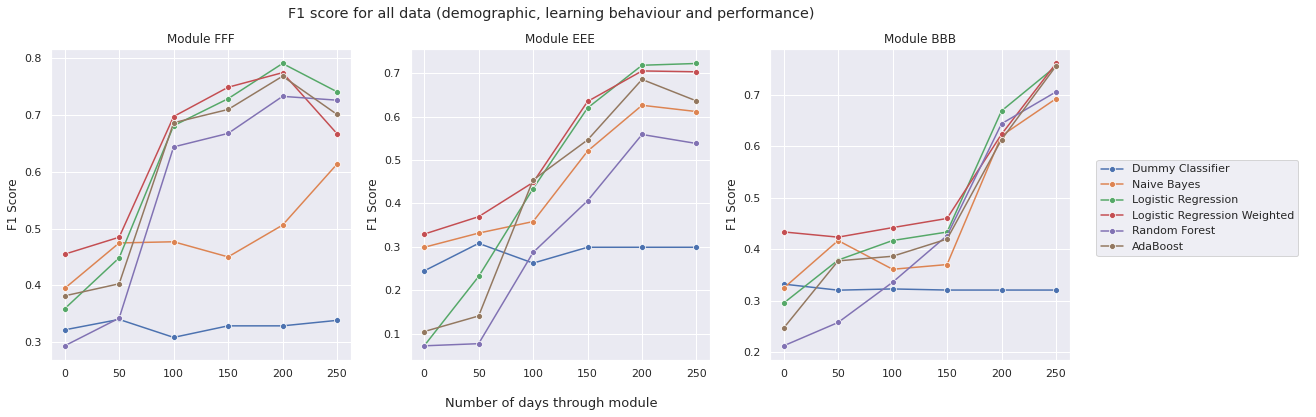

In [93]:
plot_days_compare(deadline_list,all_classifier_results,classifier_labels, "F1 score for all data (demographic, learning behaviour and performance)", module_titles, "all_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


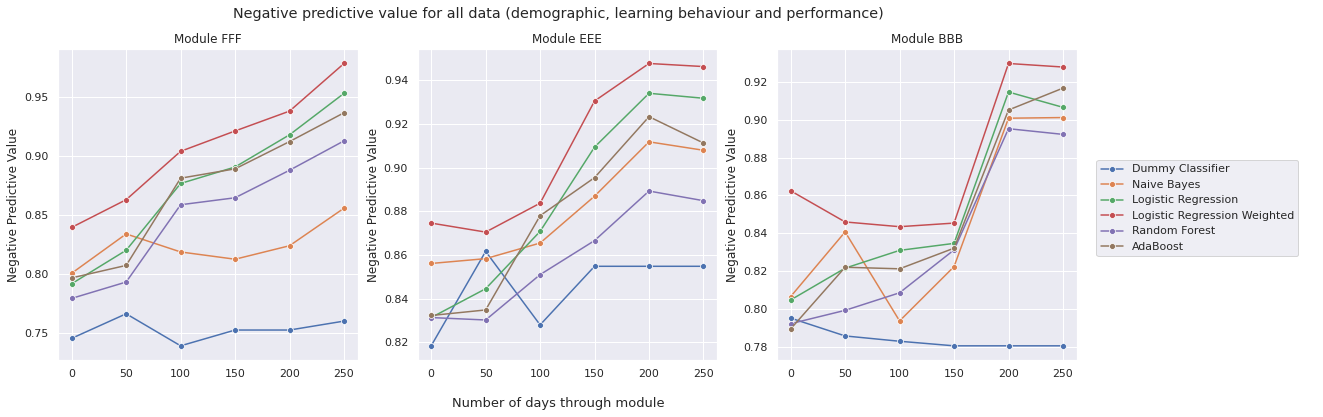

In [94]:
plot_days_compare_npv(deadline_list,all_classifier_results,classifier_labels, "Negative predictive value for all data (demographic, learning behaviour and performance)", module_titles, "all_npv.pdf")